In [4]:
# Importation des librairies
import pandas as pd
import itertools
from collections import defaultdict
from itertools import permutations,combinations
import numpy as np

In [5]:
# Utilisation d'un modèle de données déjà formatté pour le Sunburst afin de sauter des étapes. Pour ce cas-ci, aucun dédoublonnement n'a été effectué afin de considérer la contribution de tous les touch points.
# Les parcours (full journeys) sont consolidés avec leur nombre de conversions correspondantes. 
df = pd.read_csv('dataset_contributions_channels_full.csv')
df.head()

,full_journey,nb_parcours
0,SEO,2480
1,DIRECT_ACCESS,1819
2,SEA_Google_M,890
3,SEO-SEO,552
4,DIRECT_ACCESS-DIRECT_ACCESS,295


In [6]:
# Création de la fonction power_set qui renvoie toutes les combinaisons possibles pour un canal
def power_set(List):
    PS = [list(j) for i in range(len(List)) for j in itertools.combinations(List, i+1)]
    return PS

In [7]:
# Retourne tous les sous-ensembles possibles d'un ensemble de canaux

def subsets(s):
    '''
    Cette fonction renvoie tous les sous-ensembles possibles d'un ensemble de canaux.
    input :
            - s : l'ensemble des canaux.
    '''
    if len(s)==1:
        return s
    else:
        sub_channels=[]
        for i in range(1,len(s)+1):
            sub_channels.extend(map(list,itertools.combinations(s, i)))
    return list(map("-".join,map(sorted,sub_channels)))

In [8]:
# Calcul de la valeur de chaque coalition

def v_function(A,C_values):
    '''
    Cette fonction calcule la valeur de chaque coalition.
    inputs :
            - A : une coalition de chaînes.
            - C_values : Un dictionnaire contenant le nombre de conversions que chaque sous-ensemble de canaux a donné.
    '''
    subsets_of_A = subsets(A)
    #print(subsets_of_A)
    #exit()
    worth_of_A=0
    for subset in subsets_of_A:
        #print("subset:", subset)
        if subset in C_values:
            #print("subset:", subset, "; Value:", C_values[subset])
            worth_of_A += C_values[subset]
    return worth_of_A

In [9]:
# Calcul de la factorielle d'un nombre (nombre entier non négatif)

def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)

In [10]:
def calculate_shapley(df, col_name):
    '''
    Cette fonction renvoie les valeurs de Shapley
            - df : Notre dataframe composé de deux colonnes : ['full_journey', 'nb_parcours].
            La colonne channel_subset est le(s) canal(aux) associé(s) à la conversion et le count est la somme des conversions. 
            - col_name : Nom de la colonne représentant le nombre de conversions, ici cela sera 'nb_parcours'.          
    '''
    c_values = df.set_index("full_journey").to_dict()[col_name]
    df['channels'] = df['full_journey'].apply(lambda x: x if len(x.split("-")) == 1 else np.nan)
    channels = list(df['channels'].dropna().unique())
    
    v_values = {}
    for A in power_set(channels):
        v_values['-'.join(sorted(A))] = v_function(A,c_values)
    #print(v_values)
    n=len(channels)
    shapley_values = defaultdict(int)
    for channel in channels:
            for A in v_values.keys():
            #print(A)
                if channel not in A.split("-"):
                    #print(channel)
                    cardinal_A=len(A.split("-"))
                    A_with_channel = A.split("-")
                    A_with_channel.append(channel)            
                    A_with_channel="-".join(sorted(A_with_channel))
                    # Weight = |S|!(n-|S|-1)!/n!
                    weight = (factorial(cardinal_A)*factorial(n-cardinal_A-1)/factorial(n))
                    # Marginal contribution = v(S U {i})-v(S)
                    contrib = (v_values[A_with_channel]-v_values[A]) 
                    shapley_values[channel] += weight * contrib
            # Add the term corresponding to the empty set
            shapley_values[channel]+= v_values[channel]/n 
            
    return shapley_values

In [11]:
# Appel de la fonction pour visualiser la contribution de chaque canal en utilisant le modèle Shapley
print(calculate_shapley(df, "nb_parcours"))

defaultdict(<class 'int'>, {'SEO': 2639.333333333343, 'DIRECT_ACCESS': 1921.1666666666756, 'SEA_Google_M': 892.4999999999952, 'AD_EXCHANGE_appnexus': 377.16666666666714, 'SEA_Bing_M': 104.00000000000072, 'REFERRAL': 83.166666666667, 'email_auto': 68.49999999999936, 'AFFILIATION': 64.33333333333377, 'SEA_Google_HM': 49.49999999999988, 'email_tactique': 15.499999999999966, 'SOCIAL': 6.0000000000001155, 'DISPLAY': 5.8333333333334005, 'SEA_Bing_HM': 2.000000000000148})


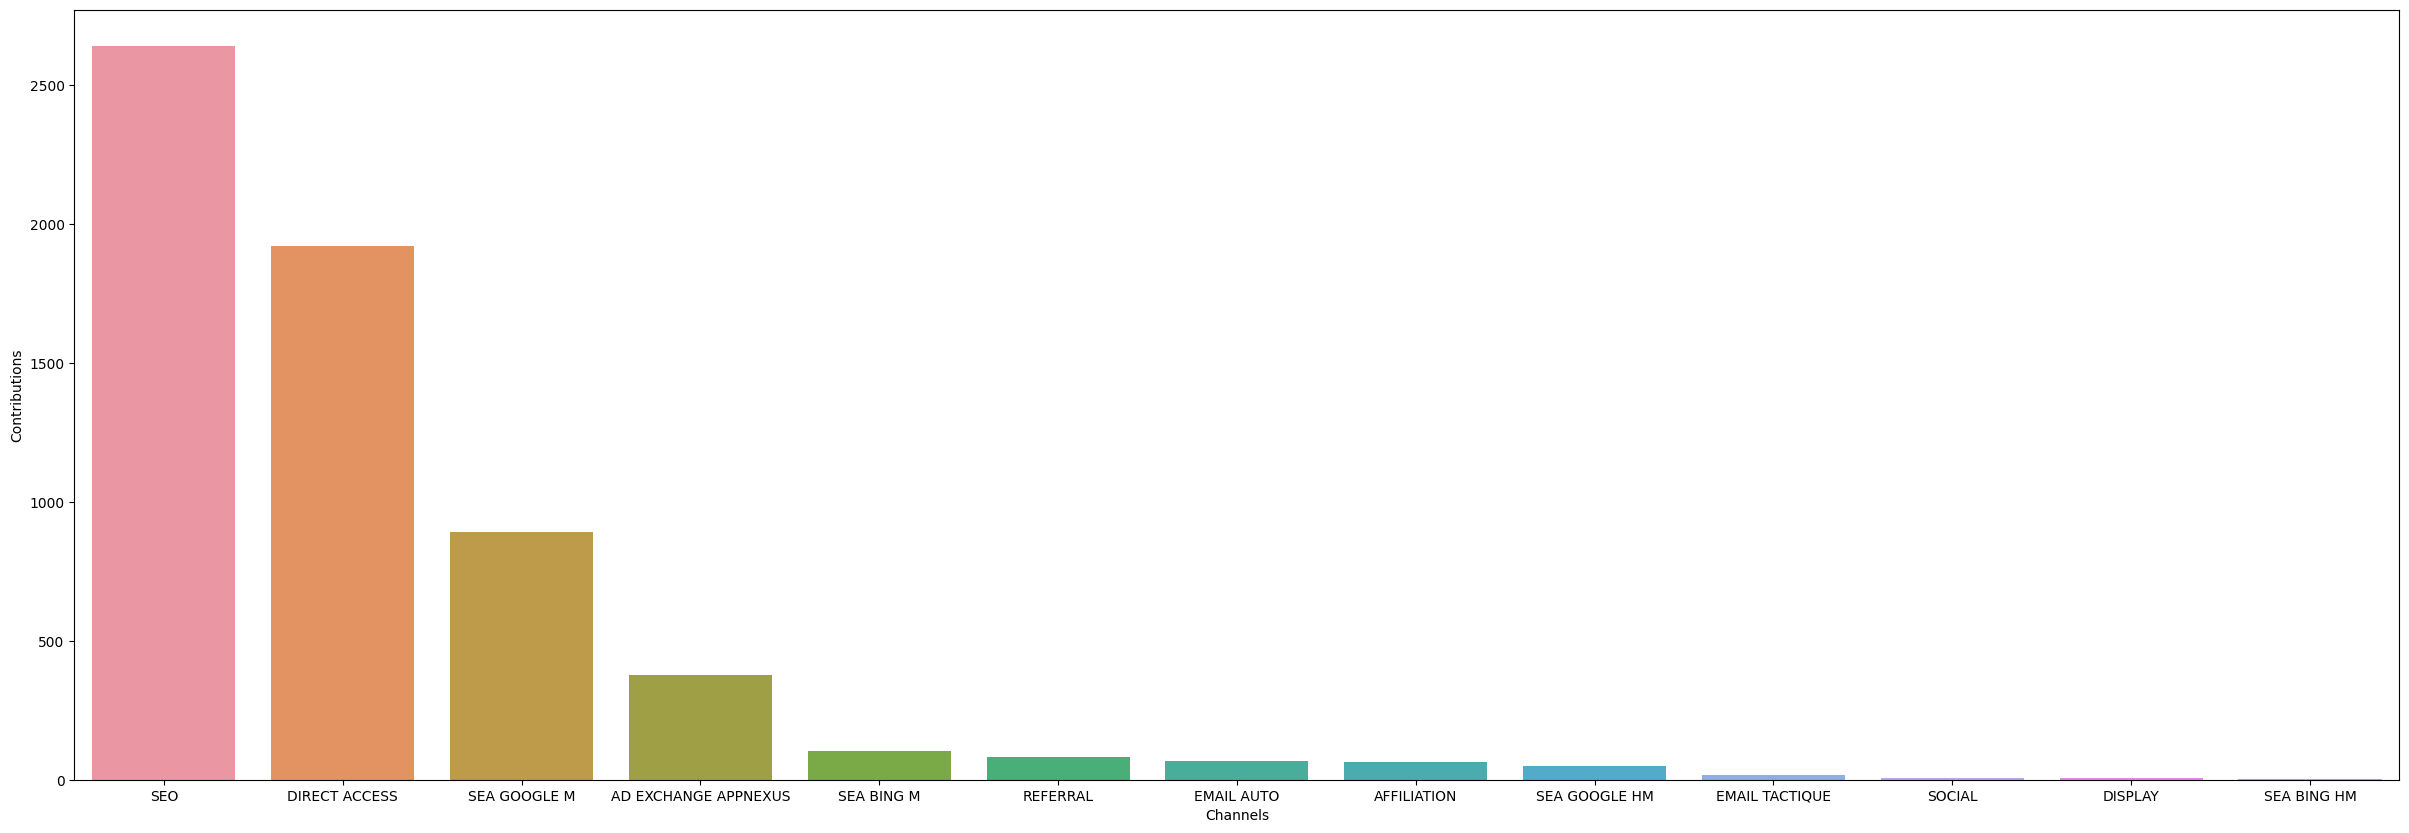

In [12]:
# Téléchargement des librairies pour la visualisation
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from pandas import DataFrame
%matplotlib inline
import seaborn as sns
result = DataFrame(list(dict(calculate_shapley(df, "nb_parcours")).items()),columns = ['Channels','Contributions'])
# Tri des contributions par ordre décroissant
result = result.sort_values(by='Contributions', ascending=False)
# Cleaning des libellés de canaux
result['Channels'] = result['Channels'].str.replace("_", " ").str.upper()

# Visualisation
plt.subplots(figsize=(30, 10))
sns.barplot(x='Channels', y='Contributions', data=result)
plt.show()